# Krystyn Gutu

**Using Unsupervised Learning models to detect whether the dataset contains anomalies or not.**

The dataset contains the temperatures (in Fahrenheit degrees) of a device on specific dates and specific times throughout a day. It contains only two columns, the date/time portion and the corresponding temperature of the device.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats

In [2]:
temp_device_failure = pd.read_csv("temperature_device_failure.csv")

In [3]:
temp_device_failure

,timestamp,value
0,7/4/2013 0:00,69.880835
1,7/4/2013 1:00,71.220227
2,7/4/2013 2:00,70.877805
3,7/4/2013 3:00,68.959400
4,7/4/2013 4:00,69.283551
...,...,...
7262,5/28/2014 11:00,72.370206
7263,5/28/2014 12:00,72.172956
7264,5/28/2014 13:00,72.046565
7265,5/28/2014 14:00,71.825226


In [4]:
print(temp_device_failure.isnull().any())

timestamp    False
value        False
dtype: bool


In [5]:
temp_device_failure.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


**Plotting / visualizing the 'original' dataset using a Time Series object.**

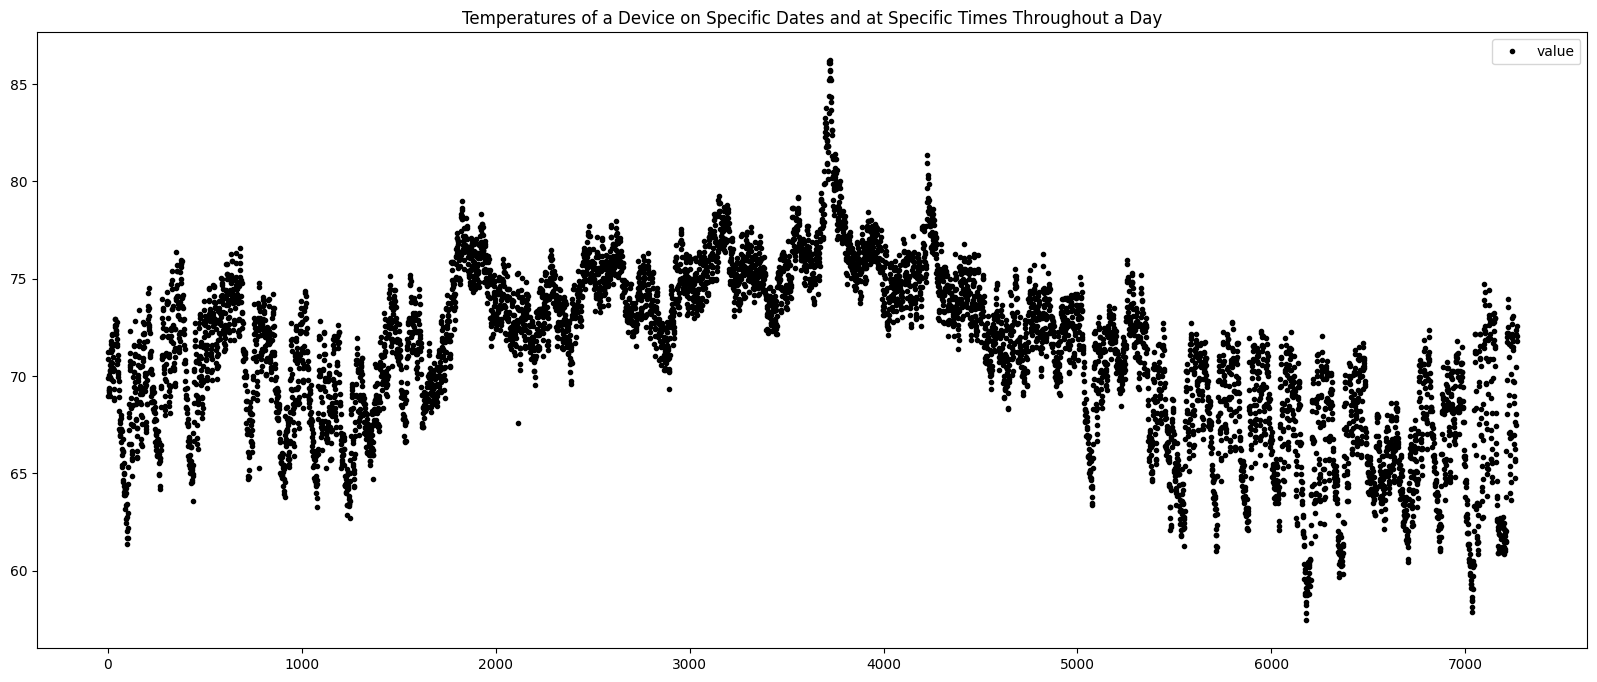

In [6]:
temp_device_failure.plot(style = "k.", figsize = (20, 8),
                         title = "Temperatures of a Device on Specific Dates and at Specific Times Throughout a Day")
plt.show()

In [7]:
graph = px.scatter(temp_device_failure, x = "timestamp", y = "value")
graph.update_xaxes(rangeslider_visible = True)
graph.show()

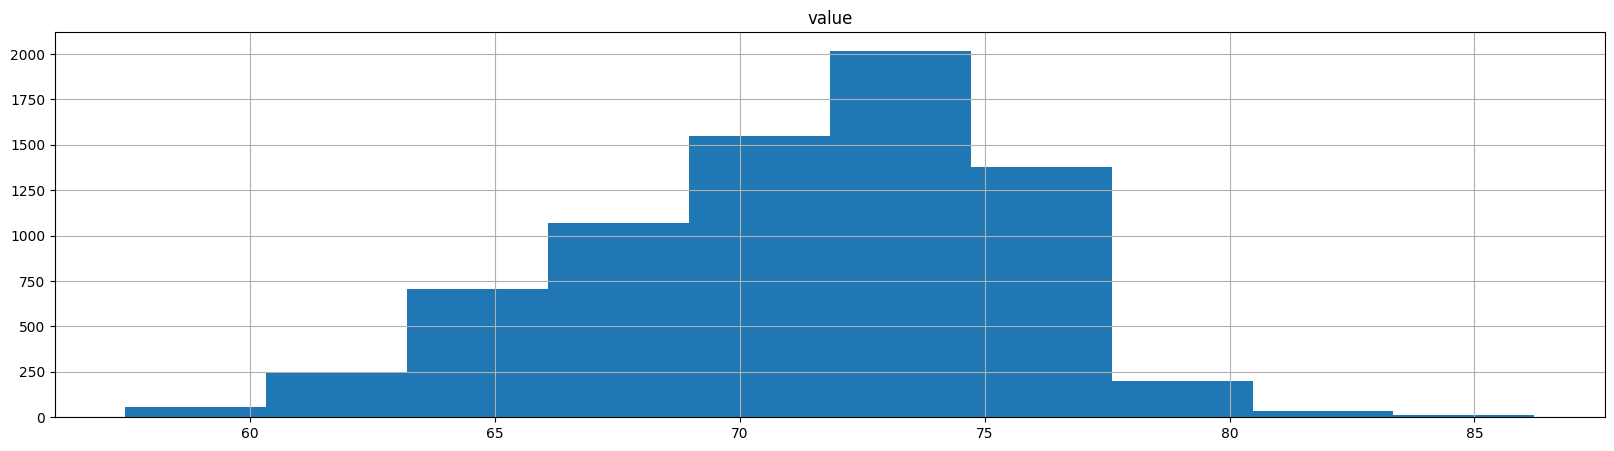

In [8]:
temp_device_failure.hist(figsize = (20, 5))
plt.show()

**Performing Feature Engineering on the dataset such that new features can be added.**

In [9]:
tdf = temp_device_failure.copy()

In [10]:
tdf.dtypes

timestamp     object
value        float64
dtype: object

In [11]:
tdf["timestamp"] = pd.to_datetime(tdf["timestamp"])

In [12]:
tdf.dtypes

timestamp    datetime64[ns]
value               float64
dtype: object

**Creating new features: Weekday Day, Weekday Night, Weekend Day, and Weekend Night.**

'Day' is defined as 7:00am - 7:00pm; and 'Night' as 7:01pm - 6:59am.

The goal is to figure out when (weekday, weekend, day or night) the device fails!

In [13]:
from datetime import datetime

tdf["dayofweek"] = tdf["timestamp"].dt.day_name()
tdf["day"] = tdf["timestamp"].dt.weekday
tdf["time"] = tdf["timestamp"].dt.time
tdf["hour"] = tdf["timestamp"].dt.hour
tdf["month"] = tdf["timestamp"].dt.month
tdf.head()

,timestamp,value,dayofweek,day,time,hour,month
0,2013-07-04 00:00:00,69.880835,Thursday,3,00:00:00,0,7
1,2013-07-04 01:00:00,71.220227,Thursday,3,01:00:00,1,7
2,2013-07-04 02:00:00,70.877805,Thursday,3,02:00:00,2,7
3,2013-07-04 03:00:00,68.959400,Thursday,3,03:00:00,3,7
4,2013-07-04 04:00:00,69.283551,Thursday,3,04:00:00,4,7


In [14]:
tdf.dtypes

timestamp    datetime64[ns]
value               float64
dayofweek            object
day                   int32
time                 object
hour                  int32
month                 int32
dtype: object

In [15]:
tdf1 = tdf.copy()
tdf1.head()

,timestamp,value,dayofweek,day,time,hour,month
0,2013-07-04 00:00:00,69.880835,Thursday,3,00:00:00,0,7
1,2013-07-04 01:00:00,71.220227,Thursday,3,01:00:00,1,7
2,2013-07-04 02:00:00,70.877805,Thursday,3,02:00:00,2,7
3,2013-07-04 03:00:00,68.959400,Thursday,3,03:00:00,3,7
4,2013-07-04 04:00:00,69.283551,Thursday,3,04:00:00,4,7


In [16]:
day_conditions = [
    (tdf1["day"] >= 5),
    (tdf1["day"] < 5)
    ]

day_values = ["weekend", "weekday"]

tdf1["daytype"] = np.select(day_conditions, day_values)

time_conditions = [
    (tdf1["hour"] >= 7) & (tdf1["hour"] <= 19),
    (tdf1["hour"] > 19) & (tdf1["hour"] < 24),
    (tdf1["hour"] < 7) & (tdf1["hour"] >= 0)
    ]

time_values = ["day", "night", "night"]

tdf1["timeframe"] = np.select(time_conditions, time_values)

season_conditions = [
    (tdf1["month"] >= 0) & (tdf1["month"] <= 2),
    (tdf1["month"] >= 3) & (tdf1["month"] <= 5),
    (tdf1["month"] >= 6) & (tdf1["month"] <= 8),
    (tdf1["month"] >= 9) & (tdf1["month"] <= 11)
    ]

season_values = ["winter", "spring", "summer", "fall"]

tdf1["season"] = np.select(season_conditions, season_values)

tdf1.head()

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season
0,2013-07-04 00:00:00,69.880835,Thursday,3,00:00:00,0,7,weekday,night,summer
1,2013-07-04 01:00:00,71.220227,Thursday,3,01:00:00,1,7,weekday,night,summer
2,2013-07-04 02:00:00,70.877805,Thursday,3,02:00:00,2,7,weekday,night,summer
3,2013-07-04 03:00:00,68.959400,Thursday,3,03:00:00,3,7,weekday,night,summer
4,2013-07-04 04:00:00,69.283551,Thursday,3,04:00:00,4,7,weekday,night,summer


In [17]:
conditions = [
    (tdf1["daytype"] == "weekend") & (tdf1["timeframe"] == "day"),
    (tdf1["daytype"] == "weekend") & (tdf1["timeframe"] == "night"),
    (tdf1["daytype"] == "weekday") & (tdf1["timeframe"] == "day"),
    (tdf1["daytype"] == "weekday") & (tdf1["timeframe"] == "night")
    ]

values = ["weekend day", "weekend night", "weekday day", "weekday night"]

tdf1["dtcat"] = np.select(conditions, values)
tdf1.head()

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season,dtcat
0,2013-07-04 00:00:00,69.880835,Thursday,3,00:00:00,0,7,weekday,night,summer,weekday night
1,2013-07-04 01:00:00,71.220227,Thursday,3,01:00:00,1,7,weekday,night,summer,weekday night
2,2013-07-04 02:00:00,70.877805,Thursday,3,02:00:00,2,7,weekday,night,summer,weekday night
3,2013-07-04 03:00:00,68.959400,Thursday,3,03:00:00,3,7,weekday,night,summer,weekday night
4,2013-07-04 04:00:00,69.283551,Thursday,3,04:00:00,4,7,weekday,night,summer,weekday night


In [18]:
tdf1.shape

(7267, 11)

In [19]:
tdf1["dtcat"].value_counts()

dtcat
weekday day      2843
weekday night    2400
weekend day      1092
weekend night     932
Name: count, dtype: int64

In [20]:
hist = px.histogram(tdf1, x = "dtcat")
hist.show()

In [21]:
hist = px.histogram(tdf1, x = "dtcat", y = "value", histfunc = "avg", nbins = 8, text_auto = True)
hist.show()

In [22]:
px.histogram(tdf1, x = "value")

In [23]:
px.histogram(tdf1, x = "season")

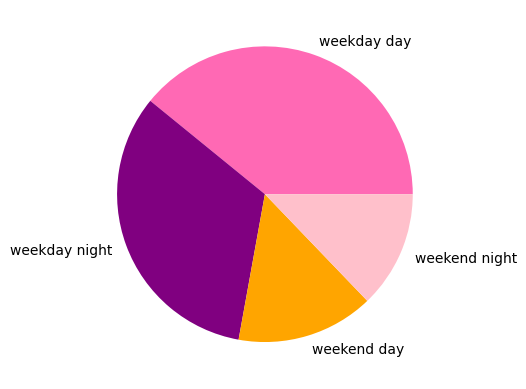

In [24]:
y = np.array([2843, 2400, 1092, 932])
mylabels = ["weekday day", "weekday night", "weekend day", "weekend night"]
mycolors = ["hotpink", "purple", "orange", "pink"]

plt.pie(y, labels = mylabels, colors = mycolors)
plt.show()

**Applying K-Means to the revised dataset and determining the best value for K.**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()

In [26]:
tdf1.dtypes

timestamp    datetime64[ns]
value               float64
dayofweek            object
day                   int32
time                 object
hour                  int32
month                 int32
daytype              object
timeframe            object
season               object
dtcat                object
dtype: object

In [27]:
from sklearn.preprocessing import LabelEncoder

tdf2 = tdf1.copy()

numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = tdf1.columns.values.tolist()
for col in features:
    if tdf2[col].dtype in numerics: continue
    categorical_columns.append(col)

for col in categorical_columns:
    if col in tdf2.columns:
        le = LabelEncoder()
        le.fit(list(tdf2[col].astype(str).values))
        tdf2[col] = le.transform(list(tdf2[col].astype(str).values))
tdf2

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season,dtcat
0,0,69.880835,4,3,0,0,7,0,1,3,1
1,1,71.220227,4,3,1,1,7,0,1,3,1
2,2,70.877805,4,3,2,2,7,0,1,3,1
3,3,68.959400,4,3,3,3,7,0,1,3,1
4,4,69.283551,4,3,4,4,7,0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
7262,7262,72.370206,6,2,11,11,5,0,0,2,0
7263,7263,72.172956,6,2,12,12,5,0,0,2,0
7264,7264,72.046565,6,2,13,13,5,0,0,2,0
7265,7265,71.825226,6,2,14,14,5,0,0,2,0


In [28]:
X = tdf2.iloc[:, : -1].values
y = tdf2.iloc[:, -1].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [30]:
from sklearn.cluster import KMeans, MiniBatchKMeans
k = 5
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [31]:
kmeans.cluster_centers_

array([[5.11450000e+03, 7.06118409e+01, 3.02291667e+00, 2.90763889e+00,
        1.15125000e+01, 1.15125000e+01, 2.13055556e+00, 2.57638889e-01,
        4.59722222e-01, 3.33611111e+00],
       [2.20800000e+03, 7.34458085e+01, 3.08111793e+00, 2.91070211e+00,
        1.15296524e+01, 1.15296524e+01, 1.00852079e+01, 2.61758691e-01,
        4.58759373e-01, 1.00000000e+00],
       [7.37000000e+02, 6.97559506e+01, 2.92338983e+00, 3.02847458e+00,
        1.14861017e+01, 1.14861017e+01, 7.65966102e+00, 2.79322034e-01,
        4.57627119e-01, 2.81288136e+00],
       [3.66800000e+03, 7.58843461e+01, 2.98141776e+00, 3.08465244e+00,
        1.15313145e+01, 1.15313145e+01, 8.38747419e+00, 2.95939436e-01,
        4.55609085e-01, 1.42532691e+00],
       [6.55050000e+03, 6.64404501e+01, 3.03631285e+00, 3.01117318e+00,
        1.14867318e+01, 1.14867318e+01, 4.30935754e+00, 2.98184358e-01,
        4.60893855e-01, 2.00000000e+00]])

In [32]:
minibatch_kmeans = MiniBatchKMeans(n_clusters = 5)
minibatch_kmeans.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



MiniBatchKMeans(n_clusters=5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

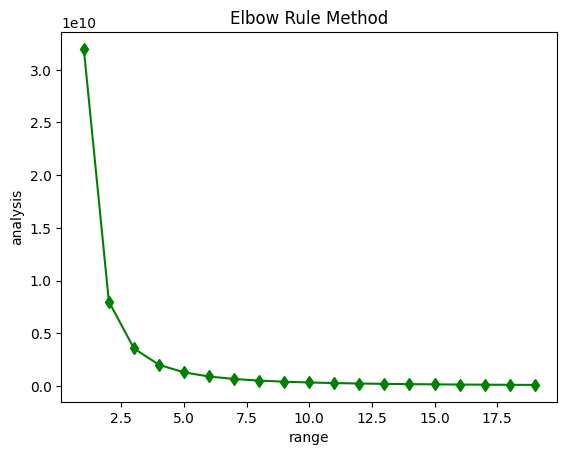

In [33]:
analysis = []
k = range(1, 20)
for i in k:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    analysis.append(kmeans.inertia_)

plt.plot(k, analysis, "-dg")
plt.xlabel("range")
plt.ylabel("analysis")
plt.title("Elbow Rule Method")
plt.show()

In [34]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(X, kmeans.labels_)
print(sil)

0.5228752636533284


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

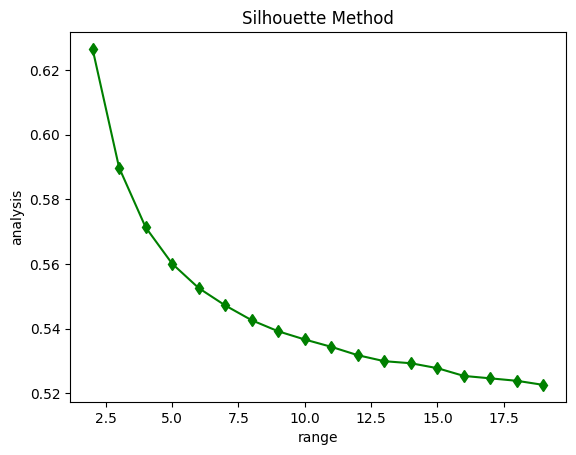

In [35]:
sil = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters = i, random_state = 42).fit(X)
    cluster_labels = kmeans.labels_
    sil.append(silhouette_score(X, cluster_labels))

plt.plot(range(2, 20), sil, "-dg")
plt.xlabel("range")
plt.ylabel("analysis")
plt.title("Silhouette Method")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



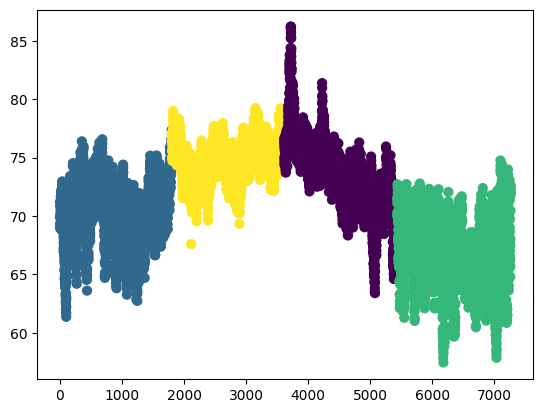

In [36]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = "viridis")

In [37]:
unique, counts = np.unique(labels, return_counts = True)

print(np.array((unique, counts)).T)

[[   0 1822]
 [   1 1802]
 [   2 1832]
 [   3 1811]]


In [38]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters = 4, rseed = 0, ax = None):
    labels = kmeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = "viridis", zorder = 2)
    ax.axis([0,7000,-2000,2000])

    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc = "#CCCCCC", lw = 3, alpha = 0.5, zorder = 1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



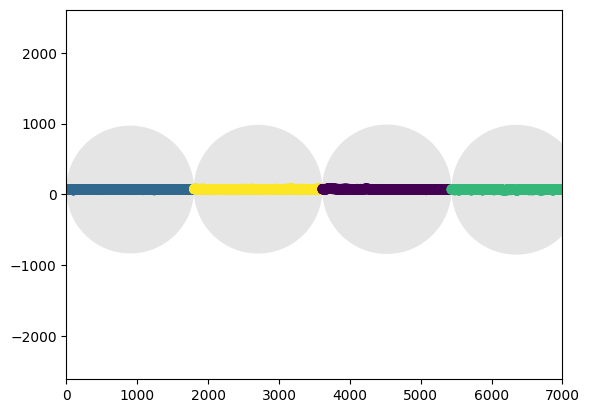

In [39]:
kmeans = KMeans(4, random_state = 0)
plot_kmeans(kmeans, X)

**Determining the best value of K, and plotting (scatter plot) the K clusters by choosing 2 features from the dataset.**

Should the dataset have more than 2 features (which is likely), Principal Component Analysis (PCA) will be applied to derive those 2 features.

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit_transform(tdf2)
pca_df = pd.DataFrame(pca)
pca_df.head()

,0,1
0,-3632.997004,-16.500501
1,-3631.997860,-15.001307
2,-3630.997644,-13.612913
3,-3629.996423,-12.328347
4,-3628.996632,-10.896038


In [41]:
pca

array([[-3.63299700e+03, -1.65005009e+01],
       [-3.63199786e+03, -1.50013066e+01],
       [-3.63099764e+03, -1.36129127e+01],
       ...,
       [ 3.63099851e+03,  2.33975255e+00],
       [ 3.63199865e+03,  3.73612355e+00],
       [ 3.63299817e+03,  5.19707171e+00]])

In [42]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(pca_df)
labels = kmeans.predict(pca_df)
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



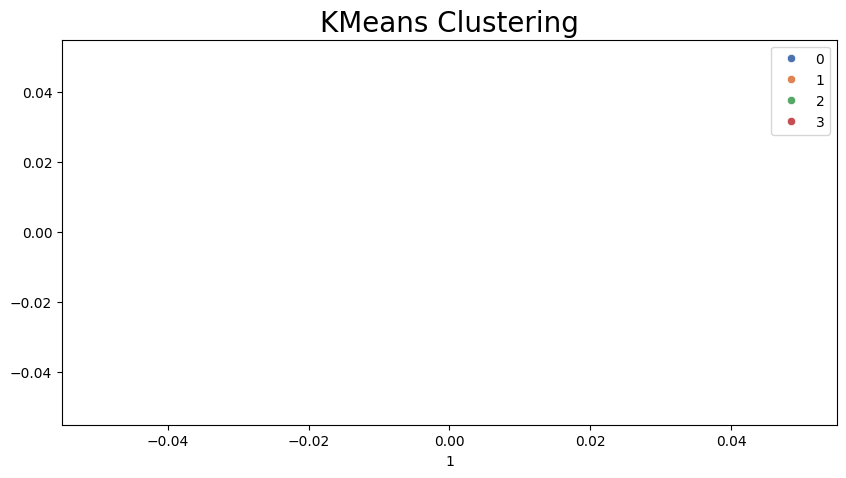

In [43]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = pca_df, x = pca_df.iloc[:, 1], hue = labels, palette = "deep")
plt.title("KMeans Clustering", size = 20)
plt.show()

In [44]:
np.random.seed(0)
my_matrix = np.random.randn(20, 5)

pca = PCA(n_components = 2)
pca = pca.fit(my_matrix)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[1.58691121 1.36183634]
[0.32047581 0.27502207]
[0.32047581 0.59549787]


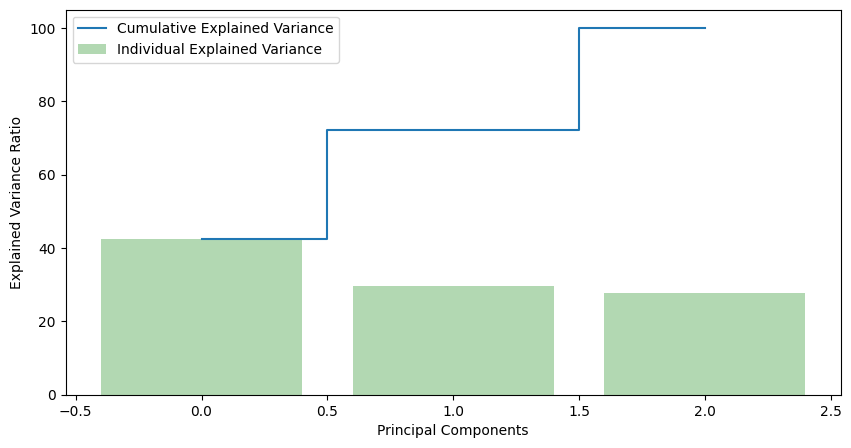

In [45]:
data = tdf2[["value", "hour", "dtcat"]]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis = 0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse = True)
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize = (10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha = 0.3, align = "center", label = "Individual Explained Variance", color = "g")
plt.step(range(len(cum_var_exp)), cum_var_exp, where = "mid", label = "Cumulative Explained Variance")
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Components")
plt.legend(loc = "best")
plt.show()

In [46]:
k = 5
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [47]:
y_pred

array([4, 4, 4, ..., 0, 0, 0], dtype=int32)

In [48]:
y_pred is kmeans.labels_

True

In [49]:
kmeans.cluster_centers_

array([[72.26150315, 12.00210637,  0.41179568],
       [65.90386849,  5.44234953,  1.24147933],
       [74.27858177, 19.48911124,  0.86403767],
       [66.55355431, 18.85061728,  1.59259259],
       [73.98989185,  3.35135135,  1.43783784]])

In [50]:
inertia = kmeans.inertia_
print(inertia)

98621.98242623053


**Applying Gaussian distribution (EllipticEnvelope), and listing the anomalies / showing them graphically.**

array([[<Axes: xlabel='value', ylabel='value'>,
        <Axes: xlabel='hour', ylabel='value'>,
        <Axes: xlabel='dtcat', ylabel='value'>],
       [<Axes: xlabel='value', ylabel='hour'>,
        <Axes: xlabel='hour', ylabel='hour'>,
        <Axes: xlabel='dtcat', ylabel='hour'>],
       [<Axes: xlabel='value', ylabel='dtcat'>,
        <Axes: xlabel='hour', ylabel='dtcat'>,
        <Axes: xlabel='dtcat', ylabel='dtcat'>]], dtype=object)

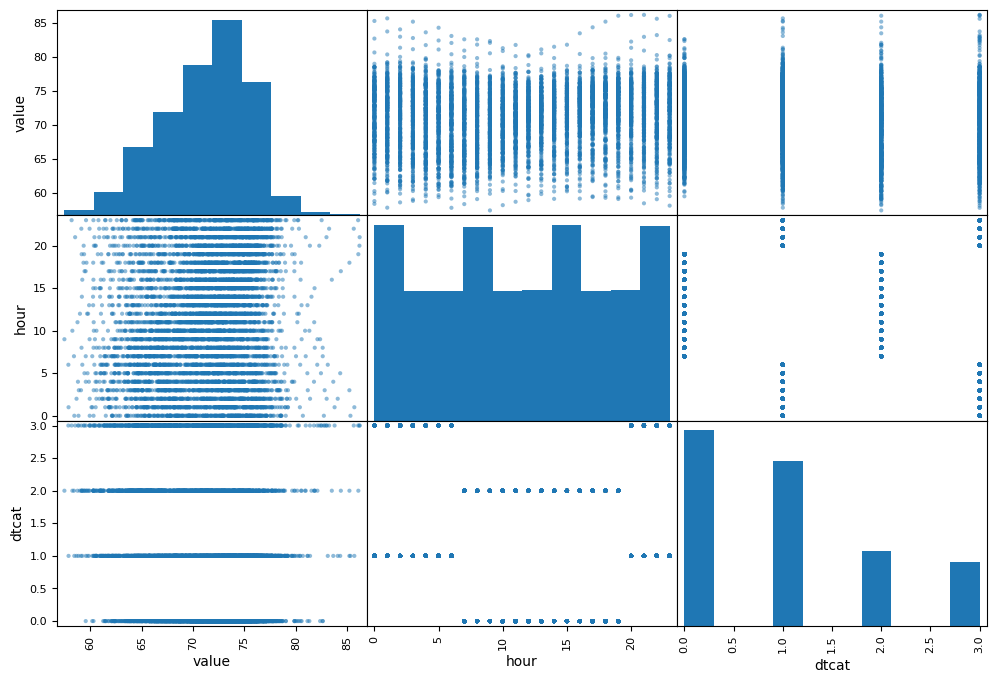

In [51]:
from pandas.plotting import scatter_matrix

attributes = ["value", "hour", "dtcat"]
scatter_matrix(tdf2[attributes], figsize = (12, 8))

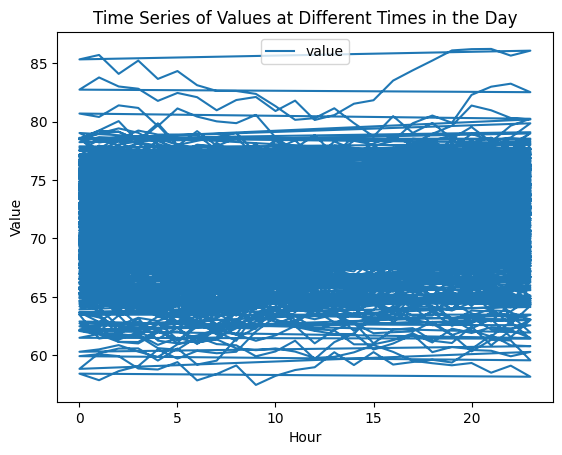

In [52]:
tdf2.plot(x = "hour", y = "value")
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("Time Series of Values at Different Times in the Day")
plt.show()

In [53]:
# df = px.data.tips()
# box = px.box(df, x = "dtcat", y = "value")
# box.show()

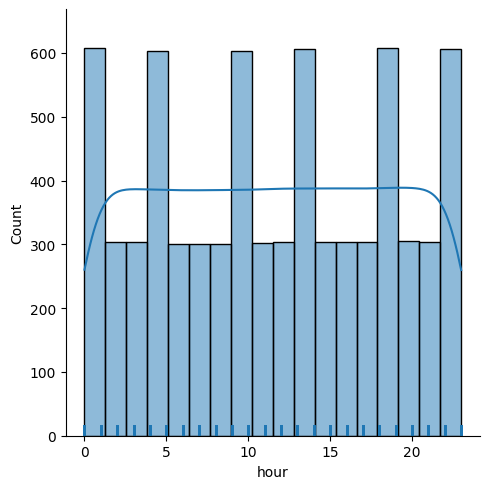

In [54]:
sns.displot(tdf2["hour"], kde = True, rug = True)
plt.show()

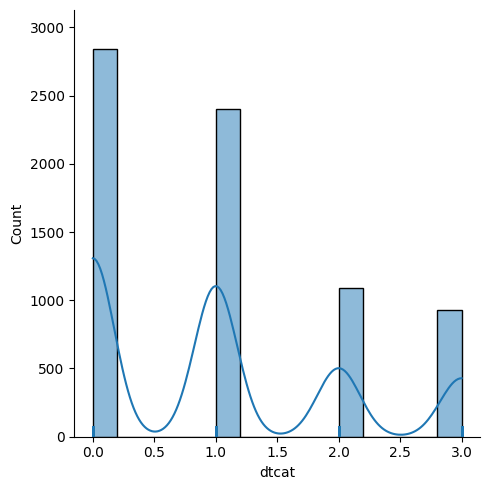

In [55]:
sns.displot(tdf2["dtcat"], kde = True, rug = True)
plt.show()

In [56]:
import scipy

In [57]:
tdf2.value.describe()

count    7267.000000
mean       71.242433
std         4.247509
min        57.458406
25%        68.369411
50%        71.858493
75%        74.430958
max        86.223213
Name: value, dtype: float64

In [58]:
outliers = px.scatter(tdf2, x = "timestamp", y = "value")
outliers.show()

In [59]:
outliers = px.box(tdf2, y = "value")
outliers.show()

In [60]:
from sklearn.covariance import EllipticEnvelope

**outliers_fraction = 0.01 (1%)**

In [63]:
covariance = EllipticEnvelope(contamination=0.01).fit(tdf2[["value"]])
prediction = pd.DataFrame(covariance.predict(tdf2[["value"]]), columns=["outlier_detection"])
tdf2_pred = pd.concat([tdf2, prediction], axis=1)
tdf2_pred["outlier_detection"] = tdf2_pred["outlier_detection"].replace([-1, 1], [True, False])
score = pd.DataFrame(covariance.decision_function(tdf2[["value"]]), columns=["score"])
tdf2_pred = pd.concat([tdf2_pred, score], axis=1)

In [64]:
outliers = tdf2_pred[tdf2_pred["outlier_detection"] == True]
outliers.head()

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season,dtcat,outlier_detection,score
3699,3699,83.247886,2,5,22,22,12,1,1,0,3,True,-0.259722
3702,3702,83.780995,3,6,1,1,12,1,1,0,3,True,-1.216688
3717,3717,83.511630,3,6,16,16,12,1,0,0,2,True,-0.727744
3718,3718,84.390932,3,6,17,17,12,1,0,0,2,True,-2.364710
3719,3719,85.227685,3,6,18,18,12,1,0,0,2,True,-4.031919


In [65]:
outliers.season.value_counts()

season
2    56
0    17
Name: count, dtype: int64

In [66]:
outliers.month.value_counts()

month
4     36
5     20
12    17
Name: count, dtype: int64

In [67]:
outliers.day.value_counts()

day
6    47
0    23
5     3
Name: count, dtype: int64

In [68]:
outliers.dtcat.value_counts()

dtcat
2    29
3    21
1    20
0     3
Name: count, dtype: int64

In [69]:
visual = px.box(tdf2_pred, x = "outlier_detection", y = "score")
visual.show()

In [70]:
outliers = px.scatter(tdf2_pred, x = "timestamp", y = "value", color = "outlier_detection")
outliers.show()

In [71]:
prediction.shape

(7267, 1)

In [72]:
pd.DataFrame(prediction).value_counts()

outlier_detection
 1                   7194
-1                     73
Name: count, dtype: int64

**Calculating outliers_fraction by finding the total number of outliers via the IQR Method (1.5 x IQR rule).**

In [73]:
tdf2.describe()

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season,dtcat
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,3633.000000,71.242433,3.008807,2.988579,11.509289,11.509289,6.539012,0.278519,0.458511,2.112976,1.015550
std,2097.946536,4.247509,2.010892,1.979945,6.927370,6.927370,3.700338,0.448301,0.498310,1.271349,1.026838
min,0.000000,57.458406,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1816.500000,68.369411,1.000000,1.000000,5.500000,5.500000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,3633.000000,71.858493,3.000000,3.000000,12.000000,12.000000,7.000000,0.000000,0.000000,2.000000,1.000000
75%,5449.500000,74.430958,5.000000,5.000000,18.000000,18.000000,10.000000,1.000000,1.000000,3.000000,2.000000
max,7266.000000,86.223213,6.000000,6.000000,23.000000,23.000000,12.000000,1.000000,1.000000,4.000000,3.000000


In [74]:
Q1 = tdf2[["hour", "value"]].quantile(0.25)
Q3 = tdf2[["hour", "value"]].quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(Q3)
print(IQR)

hour      5.500000
value    68.369411
Name: 0.25, dtype: float64
hour     18.000000
value    74.430958
Name: 0.75, dtype: float64
hour     12.500000
value     6.061547
dtype: float64


**Identifying outliers with the 1.5 x IQR rule.**

https://www.khanacademy.org/math/statistics-probability/summarizing-quantitativedata/box-whisker-plots/a/identifying-outliers-iqr-rule

In [75]:
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)

print(lower_range)
print(upper_range)

hour    -13.250000
value    59.277089
dtype: float64
hour     36.750000
value    83.523279
dtype: float64


Text(0, 0.5, 'Value')

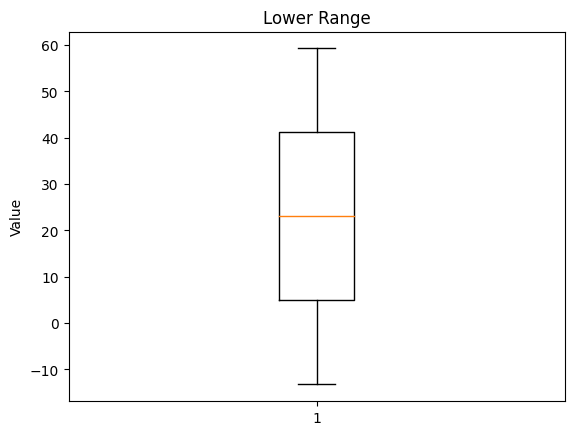

In [76]:
plt.boxplot(lower_range)
plt.title("Lower Range")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

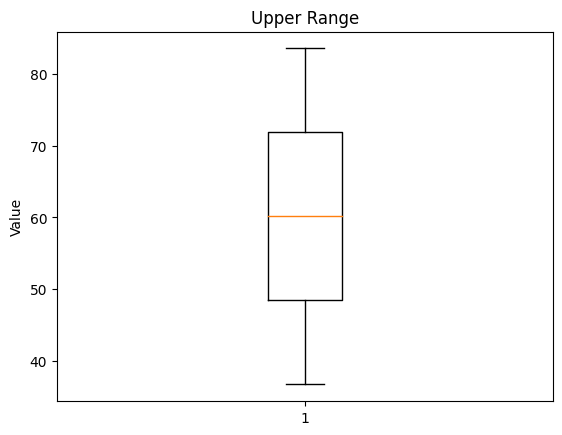

In [77]:
plt.boxplot(upper_range)
plt.title("Upper Range")
plt.ylabel("Value")

**Applying Isolation Forest for each category, and listing anomalies / showing them graphically.**

In [78]:
from sklearn.ensemble import IsolationForest

**outliers_fraction = 0.01 (1%)**

In [82]:
covariance2 = IsolationForest(contamination = 0.01)
covariance2 = covariance2.fit(tdf2[["value"]])
prediction2 = pd.DataFrame(covariance2.predict(tdf2[["value"]]), columns = ["outlier_detection"])
tdf2_pred2 = pd.concat([tdf2, prediction2], axis = 1)
tdf2_pred2["outlier_detection"] = tdf2_pred2["outlier_detection"].replace([-1, 1], [True, False])
score2 = pd.DataFrame(covariance2.decision_function(tdf2[["value"]]), columns = ["score"])
tdf2_pred2 = pd.concat([tdf2_pred2, score], axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [83]:
outliers2 = tdf2_pred2[tdf2_pred2["outlier_detection"] == True]
outliers2.head()

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season,dtcat,outlier_detection,score
3697,3697,82.289240,2,5,20,20,12,1,1,0,3,True,1.352105
3698,3698,82.989869,2,5,21,21,12,1,1,0,3,True,0.187877
3699,3699,83.247886,2,5,22,22,12,1,1,0,3,True,-0.259722
3700,3700,82.519659,2,5,23,23,12,1,1,0,3,True,0.977479
3701,3701,82.736802,3,6,0,0,12,1,1,0,3,True,0.617030


In [84]:
outliers2.season.value_counts()

season
0    41
2    30
4     2
Name: count, dtype: int64

In [85]:
outliers2.month.value_counts()

month
12    41
4     19
5     11
1      2
Name: count, dtype: int64

In [86]:
outliers2.day.value_counts()

day
6    45
0    20
5     5
1     3
Name: count, dtype: int64

In [87]:
outliers2.dtcat.value_counts()

dtcat
3    26
2    24
1    17
0     6
Name: count, dtype: int64

In [88]:
visual2 = px.box(tdf2_pred2, x = "outlier_detection", y = "score")
visual2.show()

In [89]:
outliers2 = px.scatter(tdf2_pred2, x = "timestamp", y = "value", color = "outlier_detection")
outliers2.show()

In [90]:
prediction2.shape

(7267, 1)

In [91]:
pd.DataFrame(prediction2).value_counts()

outlier_detection
 1                   7194
-1                     73
Name: count, dtype: int64

**Calculate outliers_fraction by finding total number of outliers via the IQR Method (1.5 x IQR rule).**

In [92]:
tdf2.describe()

,timestamp,value,dayofweek,day,time,hour,month,daytype,timeframe,season,dtcat
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,3633.000000,71.242433,3.008807,2.988579,11.509289,11.509289,6.539012,0.278519,0.458511,2.112976,1.015550
std,2097.946536,4.247509,2.010892,1.979945,6.927370,6.927370,3.700338,0.448301,0.498310,1.271349,1.026838
min,0.000000,57.458406,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1816.500000,68.369411,1.000000,1.000000,5.500000,5.500000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,3633.000000,71.858493,3.000000,3.000000,12.000000,12.000000,7.000000,0.000000,0.000000,2.000000,1.000000
75%,5449.500000,74.430958,5.000000,5.000000,18.000000,18.000000,10.000000,1.000000,1.000000,3.000000,2.000000
max,7266.000000,86.223213,6.000000,6.000000,23.000000,23.000000,12.000000,1.000000,1.000000,4.000000,3.000000


In [93]:
Q1_2 = tdf2[["hour", "value"]].quantile(0.25)
Q3_2 = tdf2[["hour", "value"]].quantile(0.75)
IQR_2 = Q3_2 - Q1_2

print(Q1_2)
print(Q3_2)
print(IQR_2)

hour      5.500000
value    68.369411
Name: 0.25, dtype: float64
hour     18.000000
value    74.430958
Name: 0.75, dtype: float64
hour     12.500000
value     6.061547
dtype: float64


**Identifying outliers with the 1.5 x IQR rule.**

In [94]:
lower_range2 = Q1_2 - (1.5 * IQR_2)
upper_range2 = Q3_2 + (1.5 * IQR_2)

print(lower_range2)
print(upper_range2)

hour    -13.250000
value    59.277089
dtype: float64
hour     36.750000
value    83.523279
dtype: float64


Text(0, 0.5, 'Value')

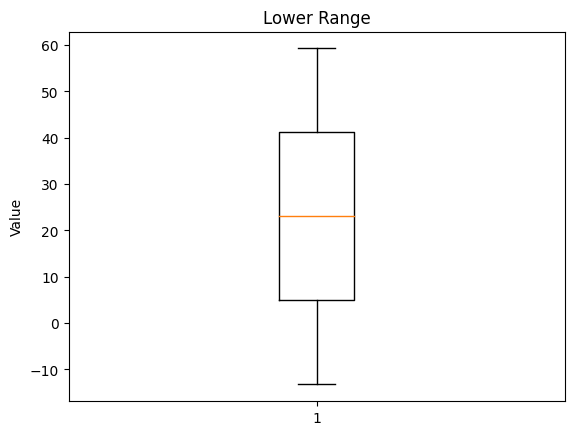

In [95]:
plt.boxplot(lower_range2)
plt.title("Lower Range")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

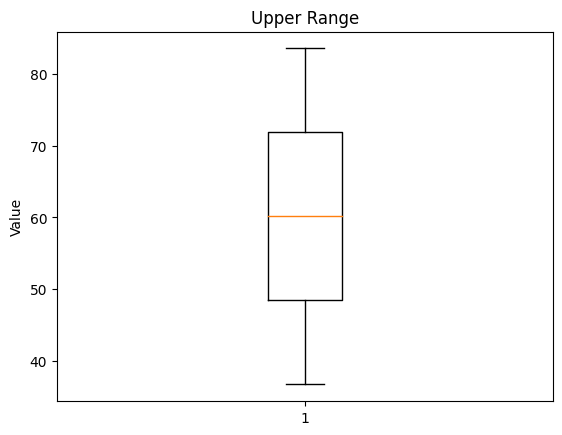

In [96]:
plt.boxplot(upper_range2)
plt.title("Upper Range")
plt.ylabel("Value")